# Cross-validation

Credit: [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html)

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data.

This situation is called **overfitting**. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set X_test, y_test.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

X, y = datasets.load_iris(return_X_y=True)
X.shape, y.shape

((150, 4), (150,))

We can now quickly sample a training set while holding out 40% of the data for testing (evaluating) our classifier:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0)

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9666666666666667

When evaluating different settings (“hyperparameters”) for estimators, such as the `C` setting that must be manually set for an SVM, there is still a risk of **overfitting** on the test set because the parameters can be tweaked until the estimator performs optimally.

To solve this problem, yet another part of the dataset can be held out as a so-called **“validation set”**: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the **test set**.

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width="400">

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called **cross-validation (CV for short)**.

## Types of Cross Validation

There are different types of cross validation methods:



### K-fold cross validation

K-fold divides all the samples in  groups of samples, called folds (if k = n, this is equivalent to *the Leave One Out strategy*), of equal sizes (if possible). The prediction function is learned using k - 1 folds, and the fold left out is used for test.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="600">


In [ ]:
import numpy as np
from sklearn.model_selection import KFold

X = ["a", "b", "c", "d"]
kf = KFold(n_splits=4)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


### Leave One Out (LOO)

LeaveOneOut (or LOO) is a simple cross-validation. Each learning set is created by taking all the samples except one, the test set being the sample left out. Thus, for n samples, we have n different training sets and n different tests set. This cross-validation procedure does not waste much data as only one sample is removed from the training set:

In [ ]:
from sklearn.model_selection import LeaveOneOut

X = [1, 2, 3, 4]
loo = LeaveOneOut()
for train, test in loo.split(X):
    print("%s %s" % (train, test))

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


### Leave P Out (LPO)

LeavePOut is very similar to LeaveOneOut as it creates all the possible training/test sets by removing p samples from the complete set.

In [ ]:
from sklearn.model_selection import LeavePOut

X = np.ones(6)
lpo = LeavePOut(p=2)
for train, test in lpo.split(X):
    print("%s %s" % (train, test))

[2 3 4 5] [0 1]
[1 3 4 5] [0 2]
[1 2 4 5] [0 3]
[1 2 3 5] [0 4]
[1 2 3 4] [0 5]
[0 3 4 5] [1 2]
[0 2 4 5] [1 3]
[0 2 3 5] [1 4]
[0 2 3 4] [1 5]
[0 1 4 5] [2 3]
[0 1 3 5] [2 4]
[0 1 3 4] [2 5]
[0 1 2 5] [3 4]
[0 1 2 4] [3 5]
[0 1 2 3] [4 5]


### Stratified k-fold

StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.



In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
X, y = np.ones((50, 1)), np.hstack(([0] * 45, [1] * 5))
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]


In [ ]:
skf = StratifiedKFold(n_splits=3)
for train, test in skf.split(X, y):
    print('train -  {}   |   test -  {}'.format(
        np.bincount(y[train]), np.bincount(y[test])))

train -  [30  3]   |   test -  [15  2]
train -  [30  3]   |   test -  [15  2]
train -  [30  4]   |   test -  [15  1]


In [ ]:
kf = KFold(n_splits=3)
for train, test in kf.split(X, y):
    print('train -  {}   |   test -  {}'.format(
        np.bincount(y[train]), np.bincount(y[test])))

train -  [28  5]   |   test -  [17]
train -  [28  5]   |   test -  [17]
train -  [34]   |   test -  [11  5]


## Computing cross-validated metrics

The simplest way to use cross-validation is to call the `cross_val_score` helper function on the estimator and the dataset.

The following example demonstrates how to estimate the accuracy of a linear kernel support vector machine on the iris dataset by splitting the data, fitting a model and computing the score 5 consecutive times (with different splits each time):

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

X, y = datasets.load_iris(return_X_y=True)

from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X, y, cv=5) 
# cv=None => default 5-fold cross validation
# cv=int => to specify the number of folds in a (Stratified)KFold
scores

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

In [2]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.98 accuracy with a standard deviation of 0.02


In [3]:
scores = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')
scores.mean()

0.9799498746867169

# Tuning the hyper-parameters

Credit: [Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)

Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. Typical examples include `C`, `kernel` and `gamma` for Support Vector Classifier, `alpha` for Lasso, etc.

**It is possible and recommended to search the hyper-parameter space for the best cross validation score.**

A search consists of:

- an estimator (regressor or classifier such as `sklearn.svm.SVC()`);
- a parameter space;
- a method for searching or sampling candidates;
- a cross-validation scheme; and
- a score function.

Two generic approaches to parameter search are provided in scikit-learn:

## Exhaustive Grid Search

The grid search provided by `GridSearchCV` exhaustively generates candidates from a grid of parameter values specified with the `param_grid` parameter.

```python
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
 ```

## Randomized Parameter Optimization

`RandomizedSearchCV` implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values.

Specifying how parameters should be sampled is done using a dictionary, very similar to specifying parameters for `GridSearchCV`.

```python
from sklearn.utils.fixes import loguniform
{
  'C': loguniform(1e0, 1e3),
  'gamma': loguniform(1e-4, 1e-3),
  'kernel': ['rbf'],
  'class_weight':['balanced', None]
}
```

In [10]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

X, y = make_hastie_10_2(n_samples=8000, random_state=42)

gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid={'min_samples_split': range(10, 401, 10)},
                  scoring='roc_auc', return_train_score=True)
gs.fit(X, y)
results = gs.cv_results_

In [11]:
X

array([[ 0.49671415, -0.1382643 ,  0.64768854, ...,  0.76743473,
        -0.46947439,  0.54256004],
       [-0.46341769, -0.46572975,  0.24196227, ...,  0.31424733,
        -0.90802408, -1.4123037 ],
       [ 1.46564877, -0.2257763 ,  0.0675282 , ...,  0.37569802,
        -0.60063869, -0.29169375],
       ...,
       [ 0.14441052, -1.95183465, -0.2304211 , ..., -1.01524769,
         0.69161761,  0.27878078],
       [-0.45237149,  1.00721805,  0.24376876, ...,  0.48044662,
        -0.10524872, -0.40348263],
       [ 0.3498234 , -1.14481581, -1.43442301, ..., -0.46895701,
        -0.00334278, -0.99348803]])

In [13]:
y

array([-1.,  1., -1., ...,  1.,  1., -1.])

In [14]:
results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [15]:
gs.best_params_

{'min_samples_split': 100}

In [16]:
results['mean_test_score']

array([0.81242259, 0.83008951, 0.84007663, 0.84679165, 0.84965323,
       0.85468875, 0.85720221, 0.86076934, 0.86100326, 0.86169206,
       0.85953517, 0.85661793, 0.85454887, 0.85352333, 0.85400337,
       0.85188977, 0.85098861, 0.84815605, 0.84534881, 0.84496066,
       0.84436749, 0.84338273, 0.84163932, 0.84037222, 0.83751389,
       0.83431037, 0.83412333, 0.83261149, 0.83024539, 0.82928109,
       0.82871824, 0.82700498, 0.82526706, 0.82428449, 0.82441841,
       0.82430168, 0.8227561 , 0.82180431, 0.81916334, 0.81874018])

In [17]:
results['rank_test_score']

array([40, 28, 22, 15, 13,  7,  5,  3,  2,  1,  4,  6,  8, 10,  9, 11, 12,
       14, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 29, 30, 31, 32, 35,
       33, 34, 36, 37, 38, 39], dtype=int32)

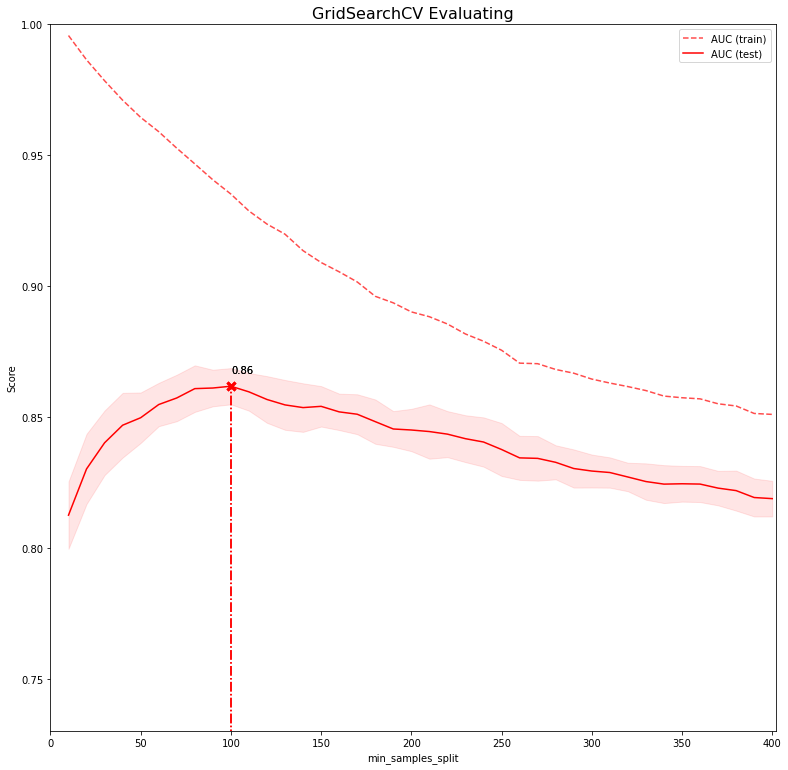

In [18]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV Evaluating",
          fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_min_samples_split'].data, dtype=float)

for sample, style in (('train', '--'), ('test', '-')):
  sample_score_mean = results['mean_%s_score' % (sample)]
  sample_score_std = results['std_%s_score' % (sample)]
  ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                  sample_score_mean + sample_score_std,
                  alpha=0.1 if sample == 'test' else 0, color='red')
  ax.plot(X_axis, sample_score_mean, style, color='red',
          alpha=1 if sample == 'test' else 0.7,
          label="AUC (%s)" % (sample))

  best_index = np.nonzero(results['rank_test_score'] == 1)[0][0]
  best_score = results['mean_test_score'][best_index]

  # Plot a dotted vertical line at the best score for that scorer marked by x
  ax.plot([X_axis[best_index], ] * 2, [0, best_score],
          linestyle='-.', color='red', marker='x', markeredgewidth=3, ms=8)

  # Annotate the best score for that scorer
  ax.annotate("%0.2f" % best_score,
              (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()